In [254]:
import numpy as np
import matplotlib.pyplot as plt
import tskit, pyslim, msprime
import h5py

In [255]:
file = '../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n'
extra ='_25k_2.5e-08U'

## infer effective population size with relate

In [256]:
# truth
filename = file + '.dynamics'
dynamics = np.loadtxt(filename, skiprows=1) #truth during forward simulation (t,N,p)
ts = dynamics[:,0]
ts = dynamics[:,0][-1] - ts #convert forward time to backwards time
Ns = dynamics[:,1]
ps = dynamics[:,2]

In [257]:
# relate
filename=file+extra+'_popsize.coal'
epochs = np.loadtxt(filename, skiprows=1, max_rows=1)
coalrates = np.loadtxt(filename, skiprows=2)[2:] #note that the coal line starts with two 0s, indicating the popns being compared (https://myersgroup.github.io/relate/modules.html)

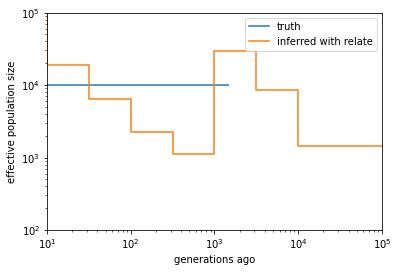

In [258]:
plt.plot(ts, Ns, label='truth')

plt.step(epochs, 0.5/coalrates, where='pre', label='inferred with relate') 

plt.xscale('log')
plt.yscale('log')
plt.xlabel('generations ago')
plt.ylabel('effective population size')
plt.xlim(1e1, 1e5)
plt.ylim(1e2,1e5)
plt.legend()
plt.show()

## infer allele frequency dynamics with clues (via relate)

and after running CLUES on the selected site we get this allele frequency

In [259]:
freqs = np.load(filename.replace('.coal','_clues.freqs.npy'))
clues_epochs = np.load(filename.replace('.coal','_clues.epochs.npy'))[:-1] #this is how clues plotting function loads the times (drops the last)
post = np.load(filename.replace('.coal','_clues.post.npy'))
clues_ps = freqs[np.argmax(post, axis=0)] #maximum likelihood frequencies

FileNotFoundError: [Errno 2] No such file or directory: '../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_popsize_clues.freqs.npy'

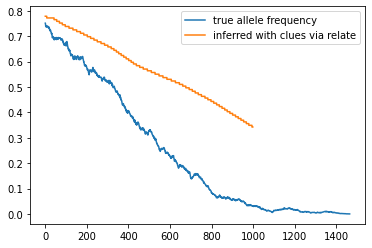

In [260]:
plt.plot(ts, ps, label='true allele frequency')
plt.step(clues_epochs, clues_ps, where='post', label='inferred with clues via relate')
plt.legend()
plt.show()

So clearly something going wrong here -- it looks from Stern et al 2019 fig 7 that CLUES can infer allele frequency trajectories well for selection coefficients as large as 0.03. But note that was CLUES-v0, which used ARGweaver trees. Now CLUES uses Relate trees, and Hejase et al 2022 show that CLUES is much worse than CLUES-v0 and greatly understimates selection coefficients for selection coefficients even as large as 0.01. This is due to tree errors, as CLUES does well with true trees (as shown in that paper). This is also consistent with Brandt et al 2022, which shows that while both ARGweaver and Relate overestimate short coalescence times, Relate does so to a larger degree. So let's look at CLUES run on the true coalescent times...

# clues (via true coalescence times)

In [261]:
freqs_true = np.load(filename.replace('.coal','_clues_true.freqs.npy'))
epochs_true = np.load(filename.replace('.coal','_clues_true.epochs.npy'))[:-1]
post_true = np.load(filename.replace('.coal','_clues_true.post.npy'))
ps_true = freqs_true[np.argmax(post_true, axis=0)]

FileNotFoundError: [Errno 2] No such file or directory: '../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_popsize_clues_true.freqs.npy'

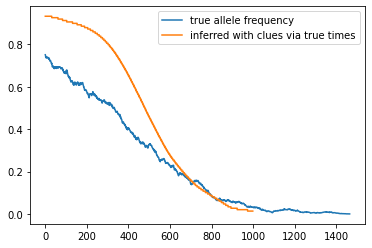

In [262]:
plt.plot(ts,ps, label='true allele frequency')
plt.step(epochs_true, ps_true, label='inferred with clues via true times')
plt.legend()
plt.show()

so why is this so far off?

is it mostly driven by the intercept? what if we supply the current freq?

# clues-v0 (via argweaver trees)

I'm now curious how ARGweaver trees would compare

In [263]:
h5file = "../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_argweaver/out.clues.h5"
h5 = h5py.File(h5file,'r')

In [264]:
xHats = h5.attrs['xHat']
argweaver_ts = h5.attrs['t'][:-1]

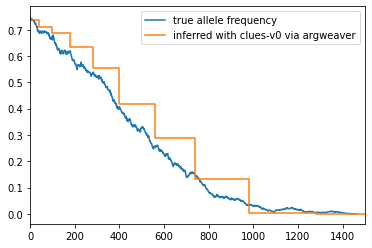

In [265]:
plt.plot(ts, ps, label='true allele frequency')
plt.step(argweaver_ts, xHats, where='post', label='inferred with clues-v0 via argweaver')
plt.legend()
plt.xlim([0,1500])
plt.show()

# all allele freqs together

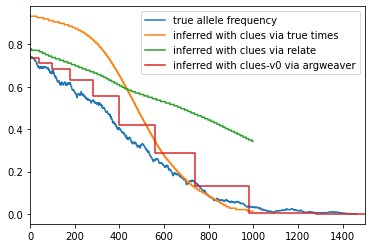

In [266]:
plt.plot(ts, ps, label='true allele frequency')
plt.step(epochs_true, ps_true, label='inferred with clues via true times')
plt.step(clues_epochs, clues_ps, where='post', label='inferred with clues via relate')
plt.step(argweaver_ts, xHats, where='post', label='inferred with clues-v0 via argweaver')
plt.xlim([0,1500])
plt.legend()
plt.show()

# selected tree

## truth

In [267]:
ts_true = tskit.load(file+extra+'.trees')
tree_true = ts_true.at(50000)

In [268]:
[i for i in ts_true.sites() if i.position==50000]

[Site(id=97, position=50000.0, ancestral_state='T', mutations=[Mutation(id=97, site=97, node=119, derived_state='A', parent=-1, metadata={'mutation_list': [{'mutation_type': 1, 'selection_coeff': 0.009999999776482582, 'subpopulation': 1, 'slim_time': 1, 'nucleotide': 0}]}, time=1465.0, edge=229)], metadata=b'')]

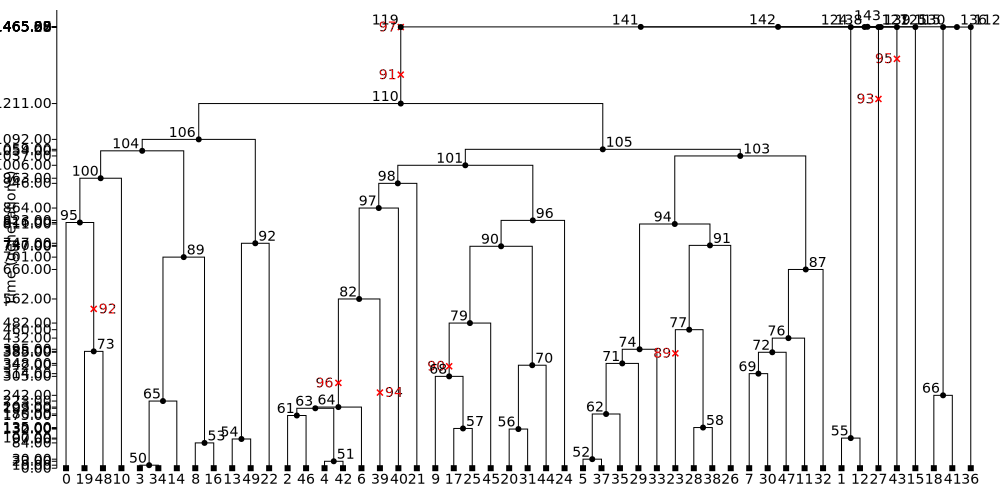

In [269]:
tree_true.draw_svg(size=(1e3,5e2), y_axis=True)

## relate

In [270]:
ts_relate = tskit.load(file+extra+'_popsize.trees')
tree_relate = ts_relate.at(50000)

In [271]:
[i for i in ts_relate.sites() if i.position==50000]

[Site(id=97, position=50000.0, ancestral_state='T', mutations=[Mutation(id=97, site=97, node=292, derived_state='A', parent=-1, metadata=b'', time=nan, edge=763)], metadata=b'')]

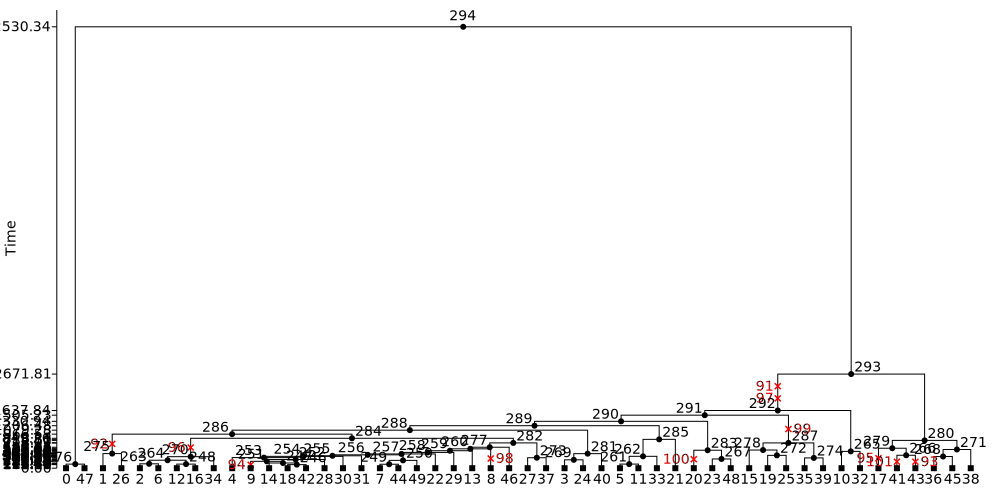

In [272]:
tree_relate.draw_svg(size=(1e3,5e2), y_axis=True)

## argweaver

## view selected tree, inferred from relate

In [56]:
from IPython.display import IFrame
plot_fn = file+extra+'_popsize.pdf'
IFrame(plot_fn, width=600, height=400)

## detect selection with relate

evidence of selection on all SNPs over time (log10 p values), https://myersgroup.github.io/relate/modules.html#Selection

In [57]:
sele = np.loadtxt(file+extra+'_popsize.sele', skiprows=1)

OSError: ../data/sim_10000K_0d_0.01s_0.5h_2B_0u_1q_100000L_1.25e-08r_0.75f_0n_25k_2.5e-08U_popsize.sele not found.

pull out evidence of selection over all time (last column)

In [58]:
# for i in range(sele.shape[1]):
plt.scatter(sele[:,0],sele[:,-1])
plt.show()

NameError: name 'sele' is not defined

In [59]:
minsele = np.min(sele[:,-1])
[i[0] for i in sele if i[-1]==minsele]

NameError: name 'sele' is not defined